In [1]:
import dgl
import torch
import numpy as np
import pickle

import matplotlib.pyplot as plt
import networkx as nx

Using backend: pytorch


In [5]:
with open ('/Users/wuyou/Downloads/edge_list.pickle','rb') as file:
    edge_list = pickle.load (file)

node_count = 34

In [6]:
def build_karate_club_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
 
    # edges are directional in DGL; make them bidirectional
    g.add_edges(dst, src)
   
    return g

In [7]:
G = build_karate_club_graph(edge_list)

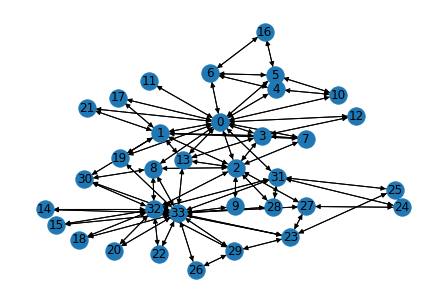

In [8]:
nx_G = G.to_networkx()

pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G,pos, with_labels = True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    return {'msg' : edges.src['h']}
    
def gcn_reduce(nodes):
    return{'h': torch.sum(nodes.mailbox['msg'],dim=1)}


class GCN_Layer(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCN_Layer,self).__init__()
        self.linear = nn.Linear(in_feats,out_feats)

    def forward (self,g,inputs):
        g.ndata['h'] = inputs
       

        g.send(g.edges(),gcn_message)
        
        g.recv(g.nodes(),gcn_reduce)
       

        h = g.ndata.pop('h')    
        

        h= self.linear(h)
       
        
        return h
        

In [11]:
class GCN(nn.Module):
    def __init__ (self, in_feats, hidden_feats, num_classes):
        super(GCN,self).__init__()
        self.gcn1 = GCN_Layer(in_feats,hidden_feats)
        self.gcn2 = GCN_Layer(hidden_feats,num_classes)
        self.softmax = nn.Softmax()

    def forward (self,g,inputs):
      
        h = self.gcn1(g,inputs)
        
        h = torch.relu(h)
       

        h = self.gcn2(g, h)
        
        h = self.softmax(h)

        

        return h


In [12]:
net = GCN(node_count,6,2)
inputs = torch.eye(node_count)
labeled_nodes = torch.tensor([0,node_count-1])
labels = torch.tensor([0,1])

In [14]:
optimizer = torch.optim.Adam(net.parameters(),lr = 0.1)

all_preds = []
epochs =20
losses = []

for epoch in range(epochs):

    preds = net(G,inputs)
    all_preds.append(preds)
    loss = F.cross_entropy(preds[labeled_nodes],labels)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print(f"Epoch { epoch} | Loss: {loss.item()}")


Epoch 0 | Loss: 0.7076268792152405
Epoch 1 | Loss: 0.4488254189491272
Epoch 2 | Loss: 0.3749324083328247
Epoch 3 | Loss: 0.3142733573913574
Epoch 4 | Loss: 0.31326791644096375
Epoch 5 | Loss: 0.31326165795326233
Epoch 6 | Loss: 0.31326165795326233
Epoch 7 | Loss: 0.31326165795326233
Epoch 8 | Loss: 0.31326165795326233
Epoch 9 | Loss: 0.31326165795326233
Epoch 10 | Loss: 0.31326165795326233
Epoch 11 | Loss: 0.31326165795326233
Epoch 12 | Loss: 0.31326165795326233
Epoch 13 | Loss: 0.31326165795326233
Epoch 14 | Loss: 0.31326165795326233
Epoch 15 | Loss: 0.31326165795326233
Epoch 16 | Loss: 0.31326165795326233
Epoch 17 | Loss: 0.31326165795326233
Epoch 18 | Loss: 0.31326165795326233
Epoch 19 | Loss: 0.31326165795326233


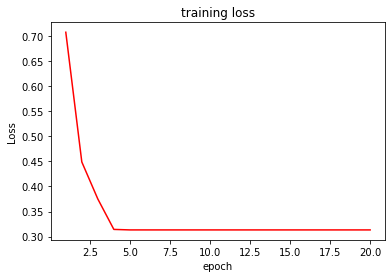

In [15]:
plt.plot(range(1, epochs+1), losses, color='r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('training loss')
plt.show()

In [17]:
lastone = all_preds[-1].detach().numpy()
predicted_class = np.argmax (lastone,axis= -1 )
predicted_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

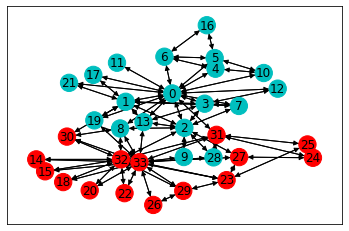

In [18]:
color = np.where(predicted_class ==0, 'c','r')
nx.draw_networkx(nx_G, pos, node_color = color ,with_labels = True )